In [1]:
%reload_ext autoreload
%autoreload 2

import os, sys
sys.path.append("..")

import numpy as np
import healpy as hp
from astropy.io import fits
from pprint import pprint
from tqdm import tqdm
import pickle
import corner

from scipy import optimize
from scipy.stats import poisson

import jax

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file('matplotlibrc')

In [3]:
from models.ebin_poisson_model import EbinPoissonModel

In [4]:
ebinmodel = EbinPoissonModel()

In [5]:
output_dir = '../output/posteriors'

In [6]:
default_expand_keys = {
    'theta_blg' : ['theta_mcdermott2022', 'theta_mcdermott2022_bbp', 'theta_mcdermott2022_x',
                   'theta_macias2019', 'theta_coleman2019'],
    'theta_ics' : ['theta_mO_ics', 'theta_ccwa_ics', 'theta_ccwf_ics'],
    'theta_pib' : ['theta_mO_pib', 'theta_ccwa_pib', 'theta_ccwf_pib'],
}

default_exclude_keys = ['auto_shared_latent']
#default_exclude_keys = []

def expand_samples(samples, expand_keys=default_expand_keys, exclude_keys=default_exclude_keys, conversion_func=(lambda x: x)):
    
    samples_new = {}
    for k in samples.keys():
        if k in exclude_keys:
            continue
        if k in expand_keys:
            for i in range(samples[k].shape[-1]):
                samples_new[expand_keys[k][i]] = conversion_func(samples[k][...,i])
        else:
            samples_new[k] = conversion_func(samples[k])
            
    return samples_new

## 1. Check SVI against HMC

### 1.1 SVI

In [39]:
svi_results = ebinmodel.fit_SVI_at_bin(
    ie=10,
    rng_key=jax.random.PRNGKey(42),
    n_steps=10000,
    guide="iaf",
    #num_base_mixture=8,
    lr=1e-4,
    num_flows=5,
    hidden_dims=[256, 256],
    num_particles=8,
)

100%|█████████████| 10000/10000 [02:55<00:00, 56.86it/s, init loss: 517065.1562, avg. loss [9501-10000]: 32438.5645]


In [40]:
samples = ebinmodel.get_svi_samples(num_samples=50000)
pickle.dump((samples, svi_results), open(f'{output_dir}/check_SVI/ebin10_smp_svi.p', 'wb'))

### 1.2 PTHMC

In [13]:
ebinmodel.run_parallel_tempering_hmc(num_samples=20000)

sample: 100%|█████████████████████████████████████████████████████████████████| 20600/20600 [12:40<00:00, 27.08it/s]


In [14]:
pickle.dump(ebinmodel.pt_mcmc.get_samples(), open(f'{output_dir}/check_SVI/ebin10_pthmc.p', 'wb'))

### 1.3 MAP

In [31]:
svi_results = ebinmodel.fit_MAP_at_bin(ie=10, n_steps=30000)

100%|███████████| 30000/30000 [01:27<00:00, 341.02it/s, init loss: 374576.0938, avg. loss [28501-30000]: 31908.4336]


In [34]:
ebinmodel.MAP_estimates['f_blg'] = ebinmodel.MAP_estimates['S_blg'] / (ebinmodel.MAP_estimates['S_blg'] + ebinmodel.MAP_estimates['S_nfw'])

In [35]:
pickle.dump(
    (expand_samples(ebinmodel.MAP_estimates), svi_results),
    open(f'{output_dir}/check_SVI/ebin10_MAP.p', 'wb'),
)

### 1.4 compare

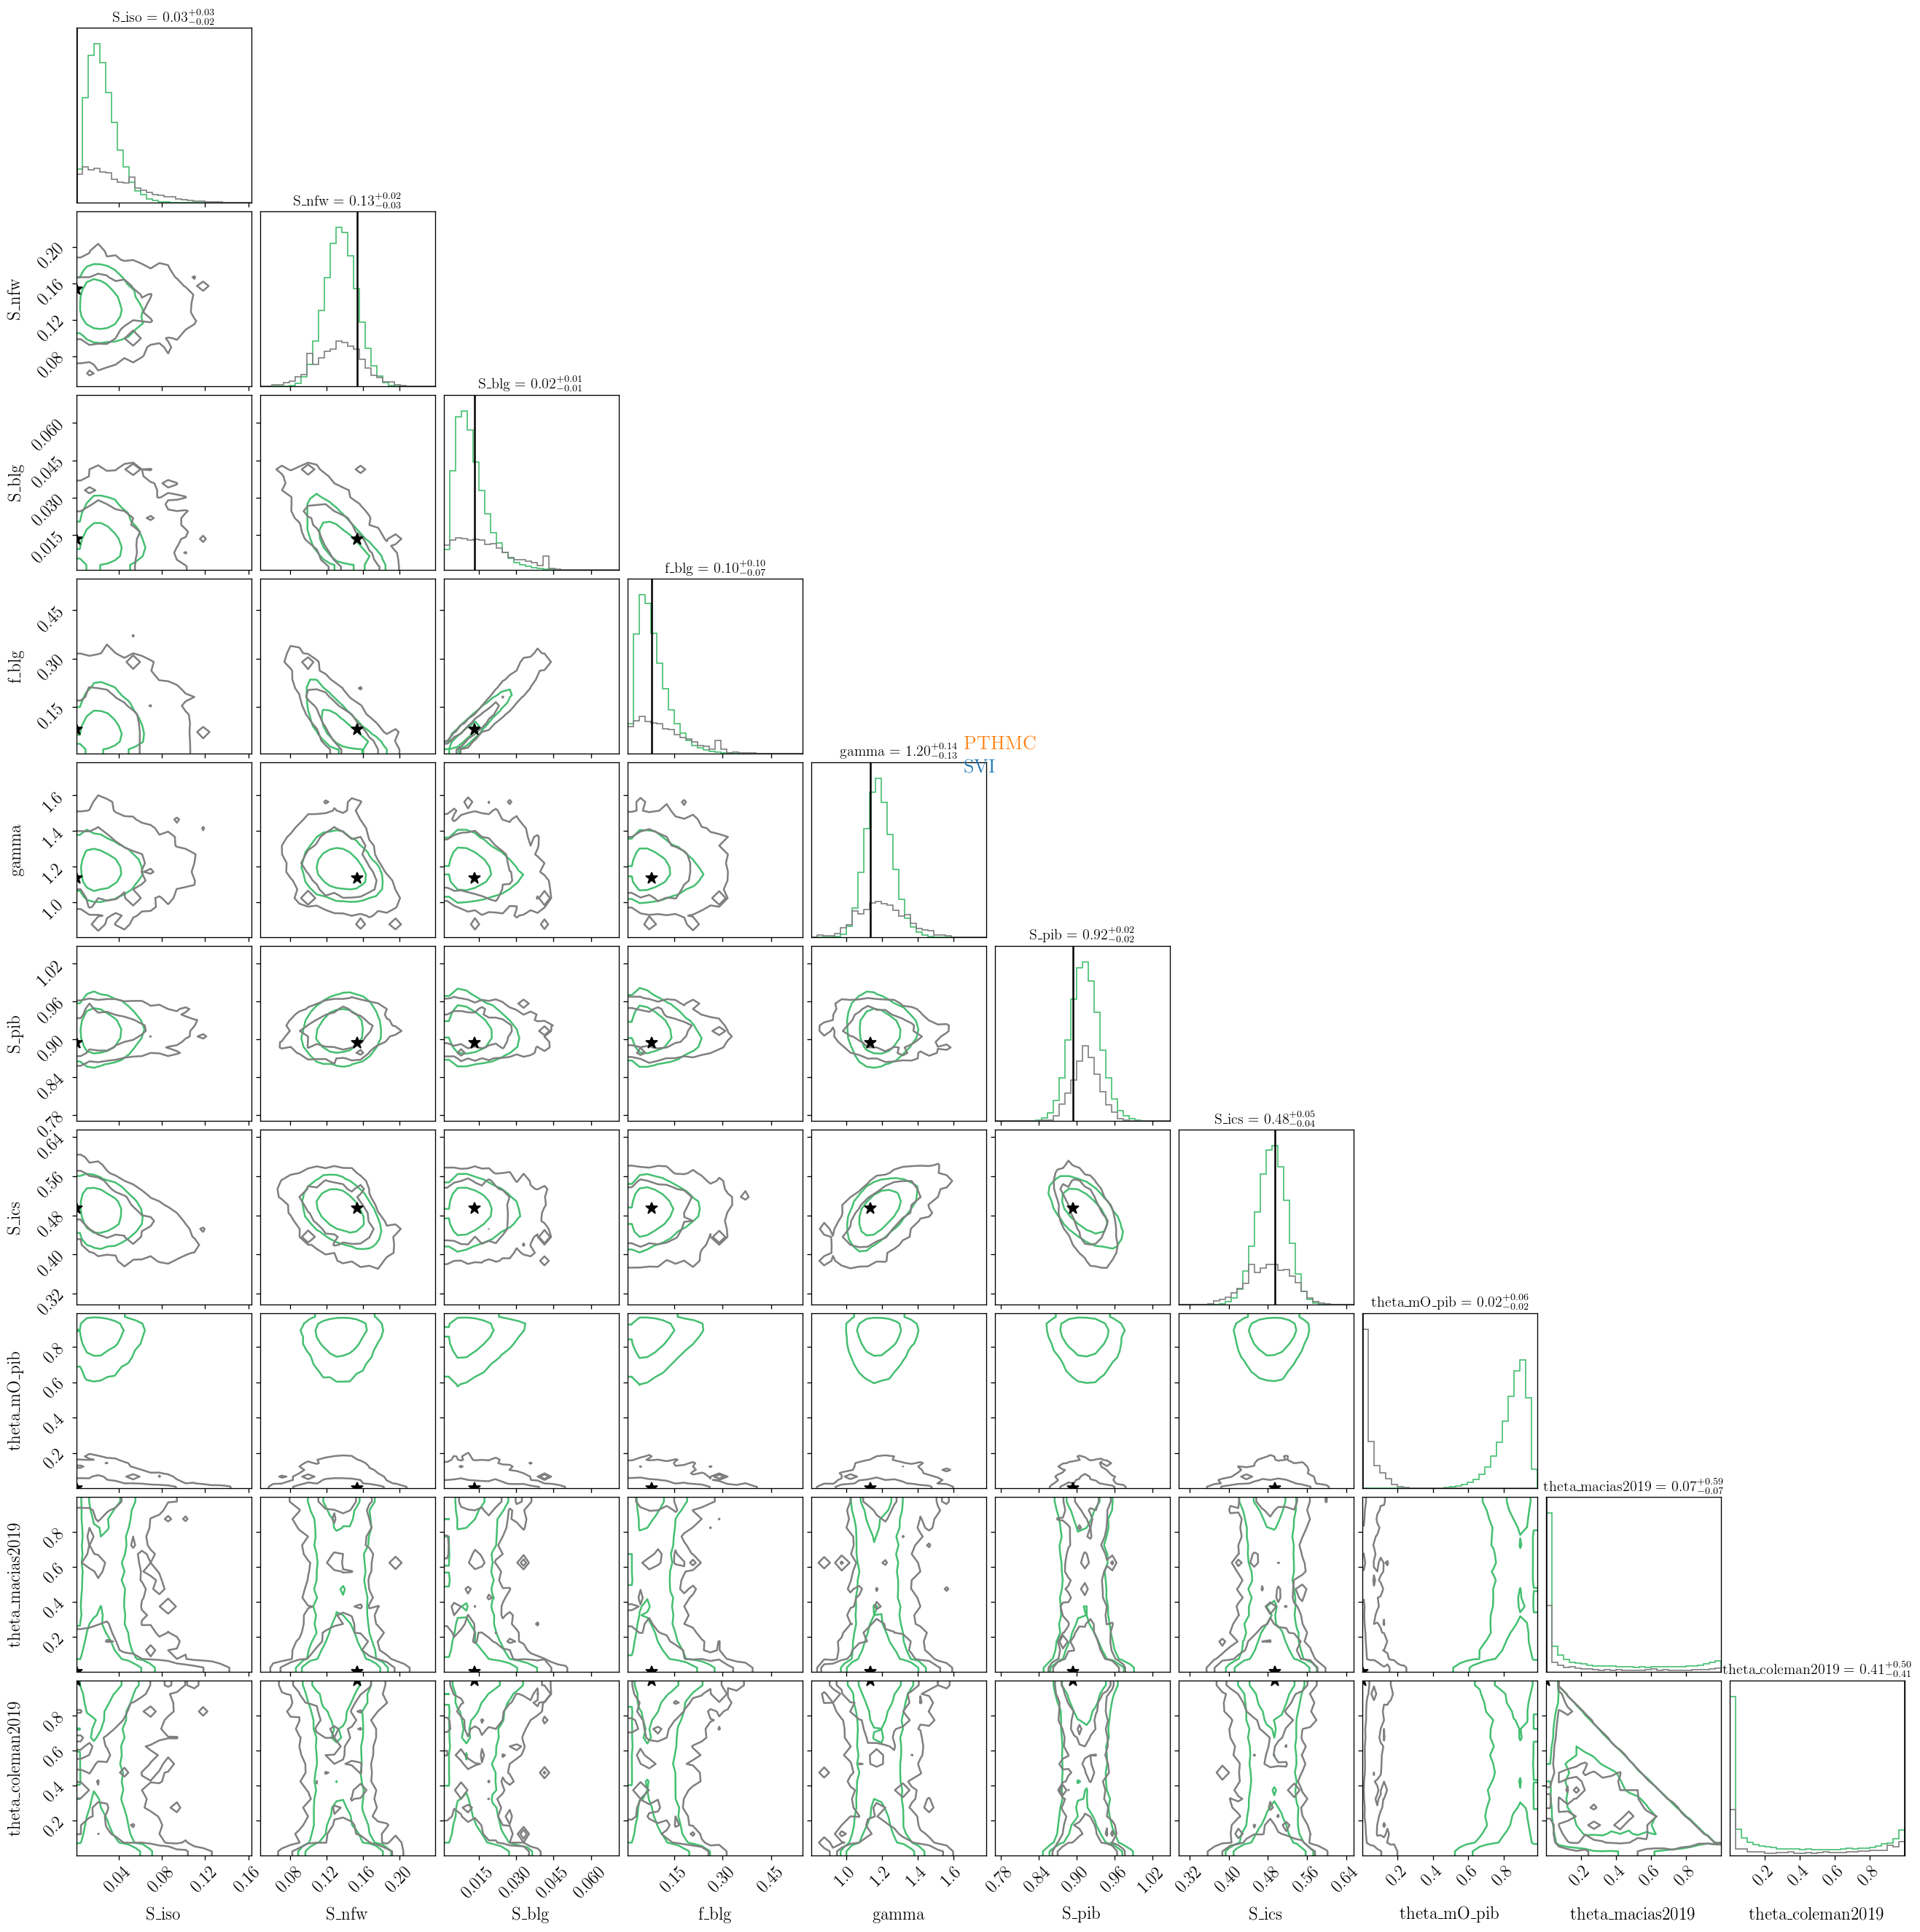

In [43]:
s0, _ = pickle.load(open(f'{output_dir}/check_SVI/ebin10_smp_svi.p', 'rb'))
s1 = expand_samples(pickle.load(open(f'{output_dir}/check_SVI/ebin10_pthmc.p', 'rb')))
samples_dict = {
    'SVI' : s0,
    'PTHMC' : s1,
}
colors_dict = {
    'SVI' : mpl.cm.get_cmap('viridis')(0.7),
    'PTHMC' : mpl.cm.get_cmap('binary')(0.5),
}

plot_var_names = [
    'S_iso', 'S_nfw', 'S_blg', 'f_blg', 'gamma', 'S_pib', 'S_ics',
    'theta_mO_pib', 'theta_macias2019', 'theta_coleman2019',
]

n_bins_1d = 30
bins_1d_arr = []
for vn in plot_var_names:
    vmin = np.min([np.min(s[vn]) for _, s in samples_dict.items()])
    vmax = np.max([np.max(s[vn]) for _, s in samples_dict.items()])
    bins_1d_arr.append(np.linspace(vmin, vmax, n_bins_1d + 1))

figure = None
for i, (samples_name, samples) in enumerate(samples_dict.items()):
    color = f'C{i}'
    figure = corner.corner(
        samples,
        bins_1d_arr=bins_1d_arr,
        var_names=plot_var_names,
        show_titles=True,
        title_kwargs={"fontsize": 12},
        levels = [0.68, 0.95],
        #color = mpl.colors.to_hex(mpl.colors.to_rgb(f'C{i}') + (alphas[i],), keep_alpha=True),
        color = mpl.colors.to_hex(colors_dict[samples_name]),
        plot_contours=True,
        fill_contours=False,
        plot_density=False,
        plot_datapoints=False,
        fig=figure,
        #alpha=alphas[i]
    )
    figure.text(0.5, 0.6+0.012*i, samples_name, fontsize=16, color=color)

ndim = len(plot_var_names)
axs = np.array(figure.axes).reshape((ndim, ndim))

MAP_estimates, _ = pickle.load(open(f'{output_dir}/check_SVI/ebin10_MAP.p', 'rb'))

for i, v in enumerate(plot_var_names):
    axs[i,i].axvline(MAP_estimates[v], color='k')
    
for ri in range(ndim):
    for ci in range(ri):
        axs[ri,ci].plot(MAP_estimates[plot_var_names[ci]], MAP_estimates[plot_var_names[ri]], '*', color='k', ms=10)

## 2. Run for all energy bins

In [ ]:
for ie in range(10, 20):
    print('ebin: ', ie)
    svi_results = ebinmodel.fit_SVI_at_bin(
        ie=ie,
        rng_key=jax.random.PRNGKey(42),
        n_steps=7500,
        guide="iaf_mixture",
        num_base_mixture=8,
        lr=5e-5,
        num_flows=5,
        hidden_dims=[256, 256],
        num_particles=8,
    )
    samples = ebinmodel.get_svi_samples(num_samples=50000)
    pickle.dump(samples, open(f'{data_dir}/test_bin{ie}.p', 'wb'))

## 3. View

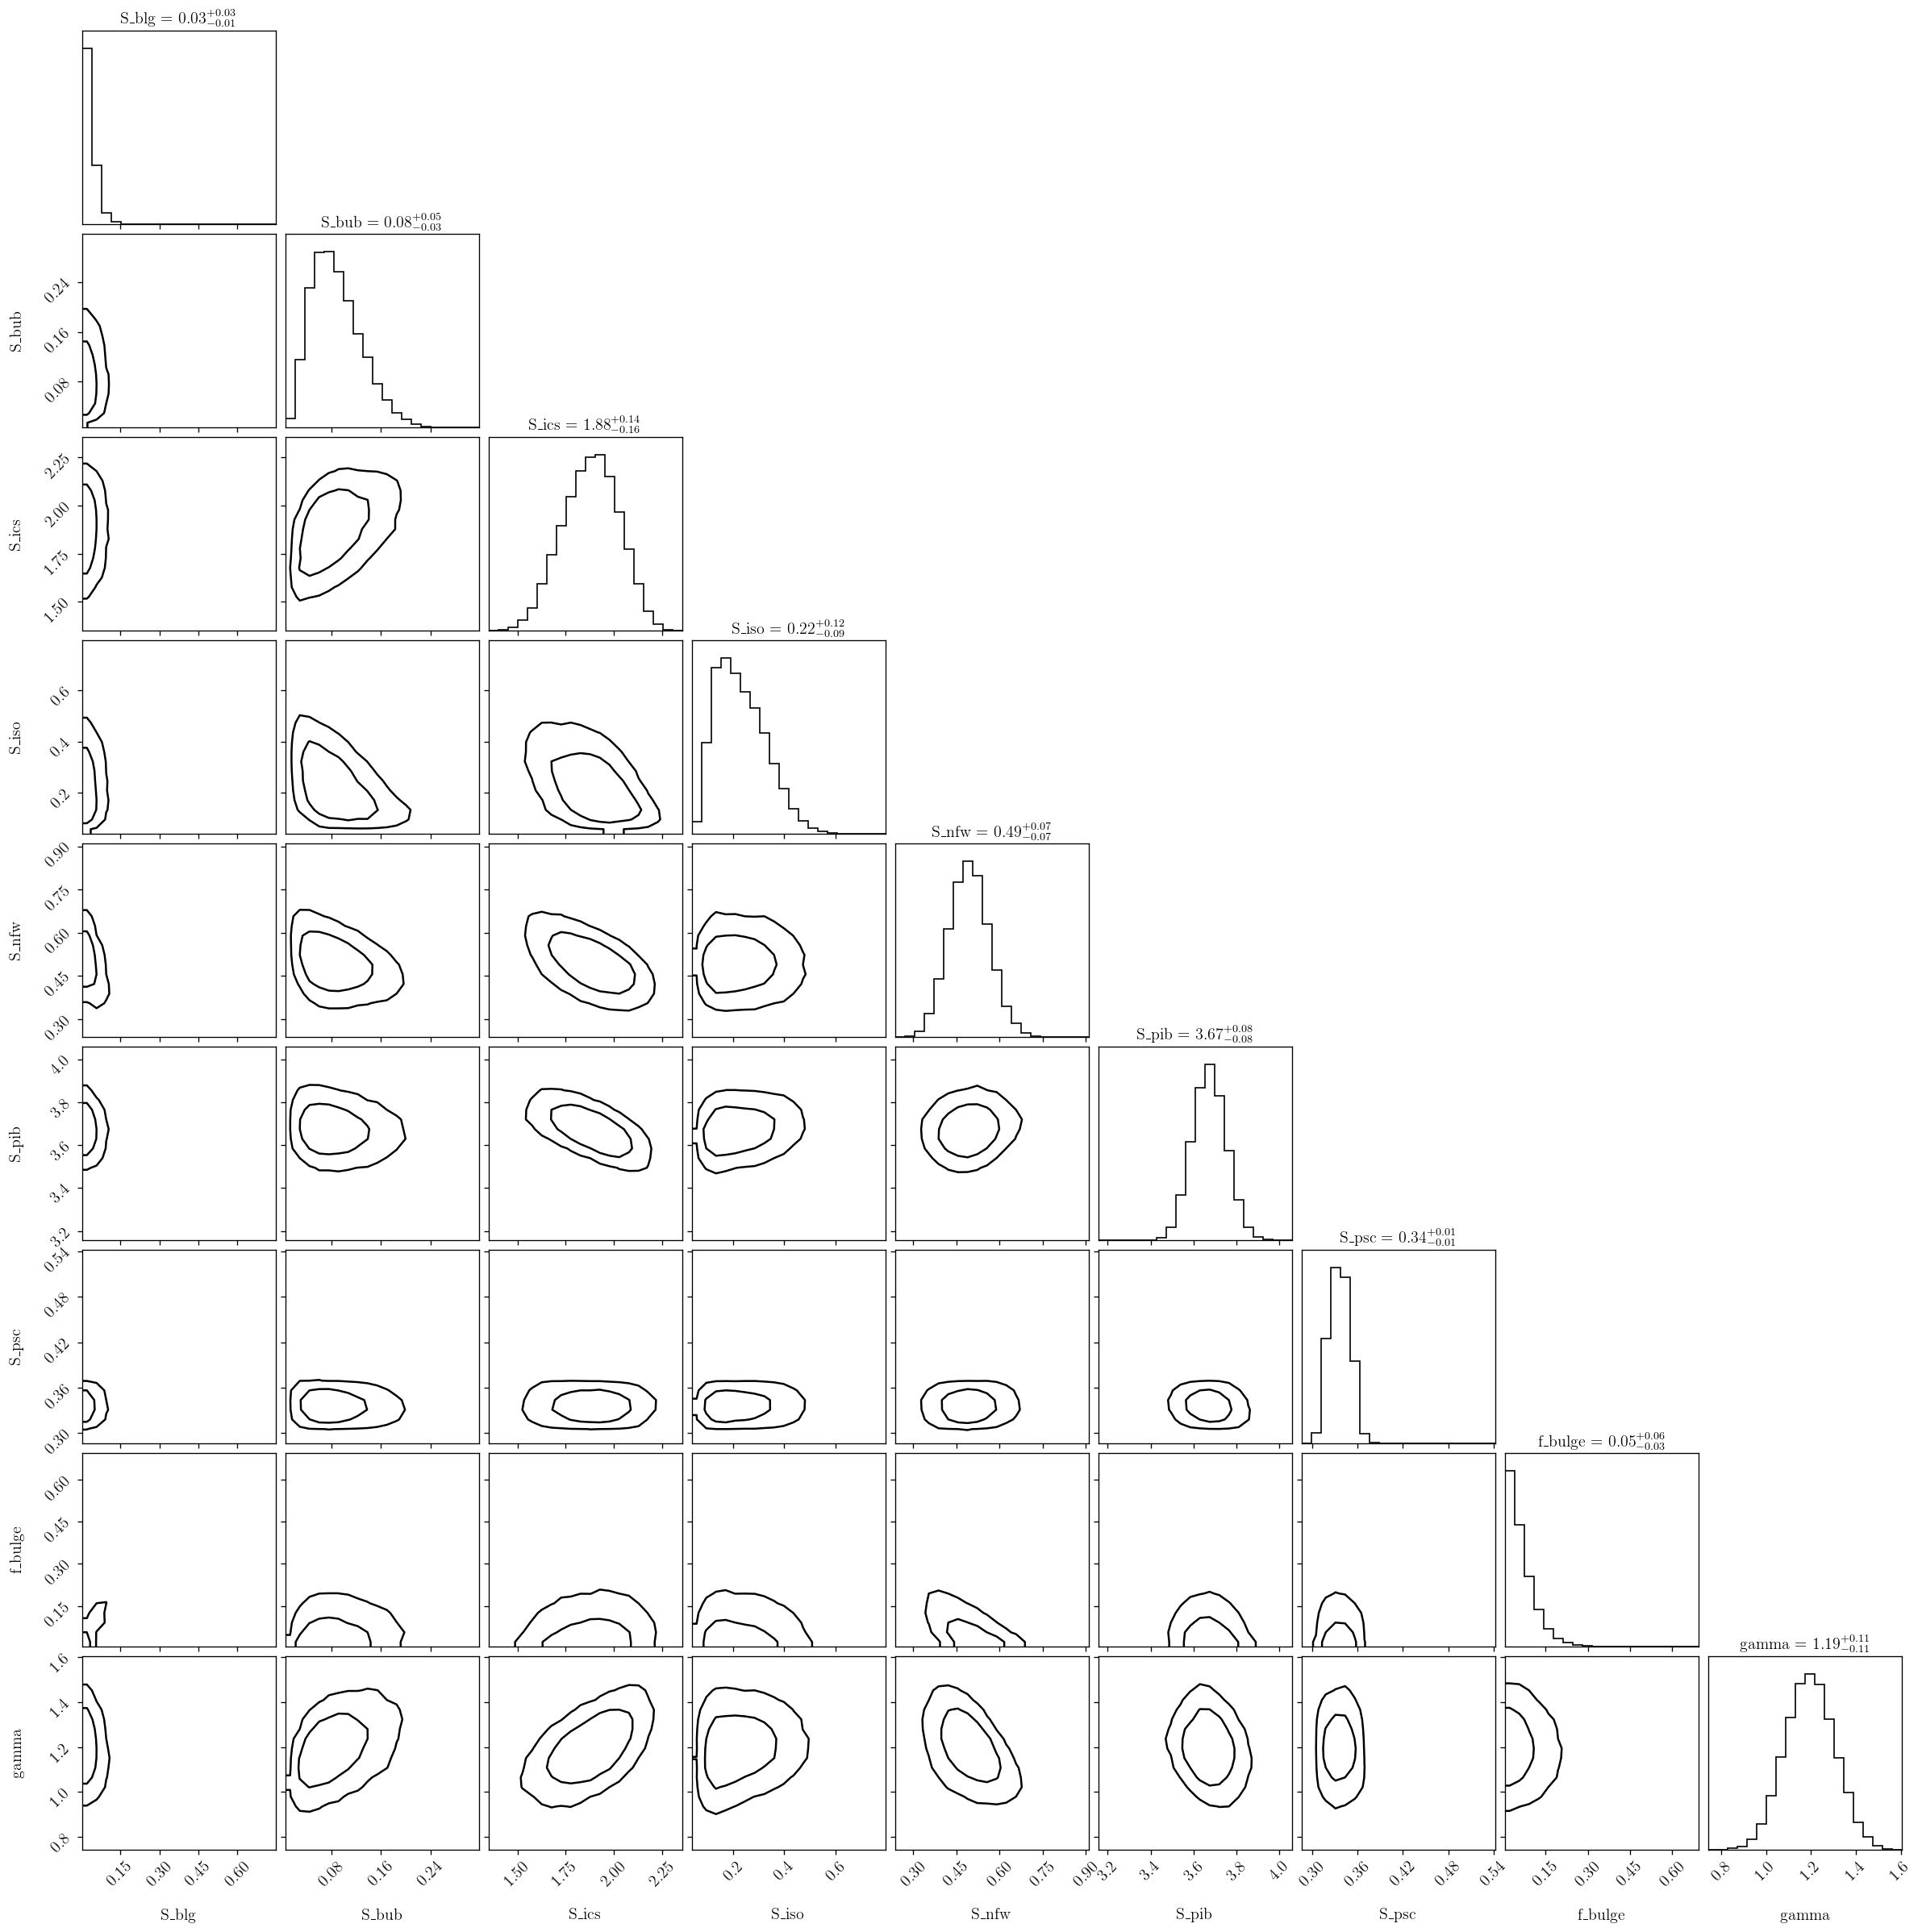

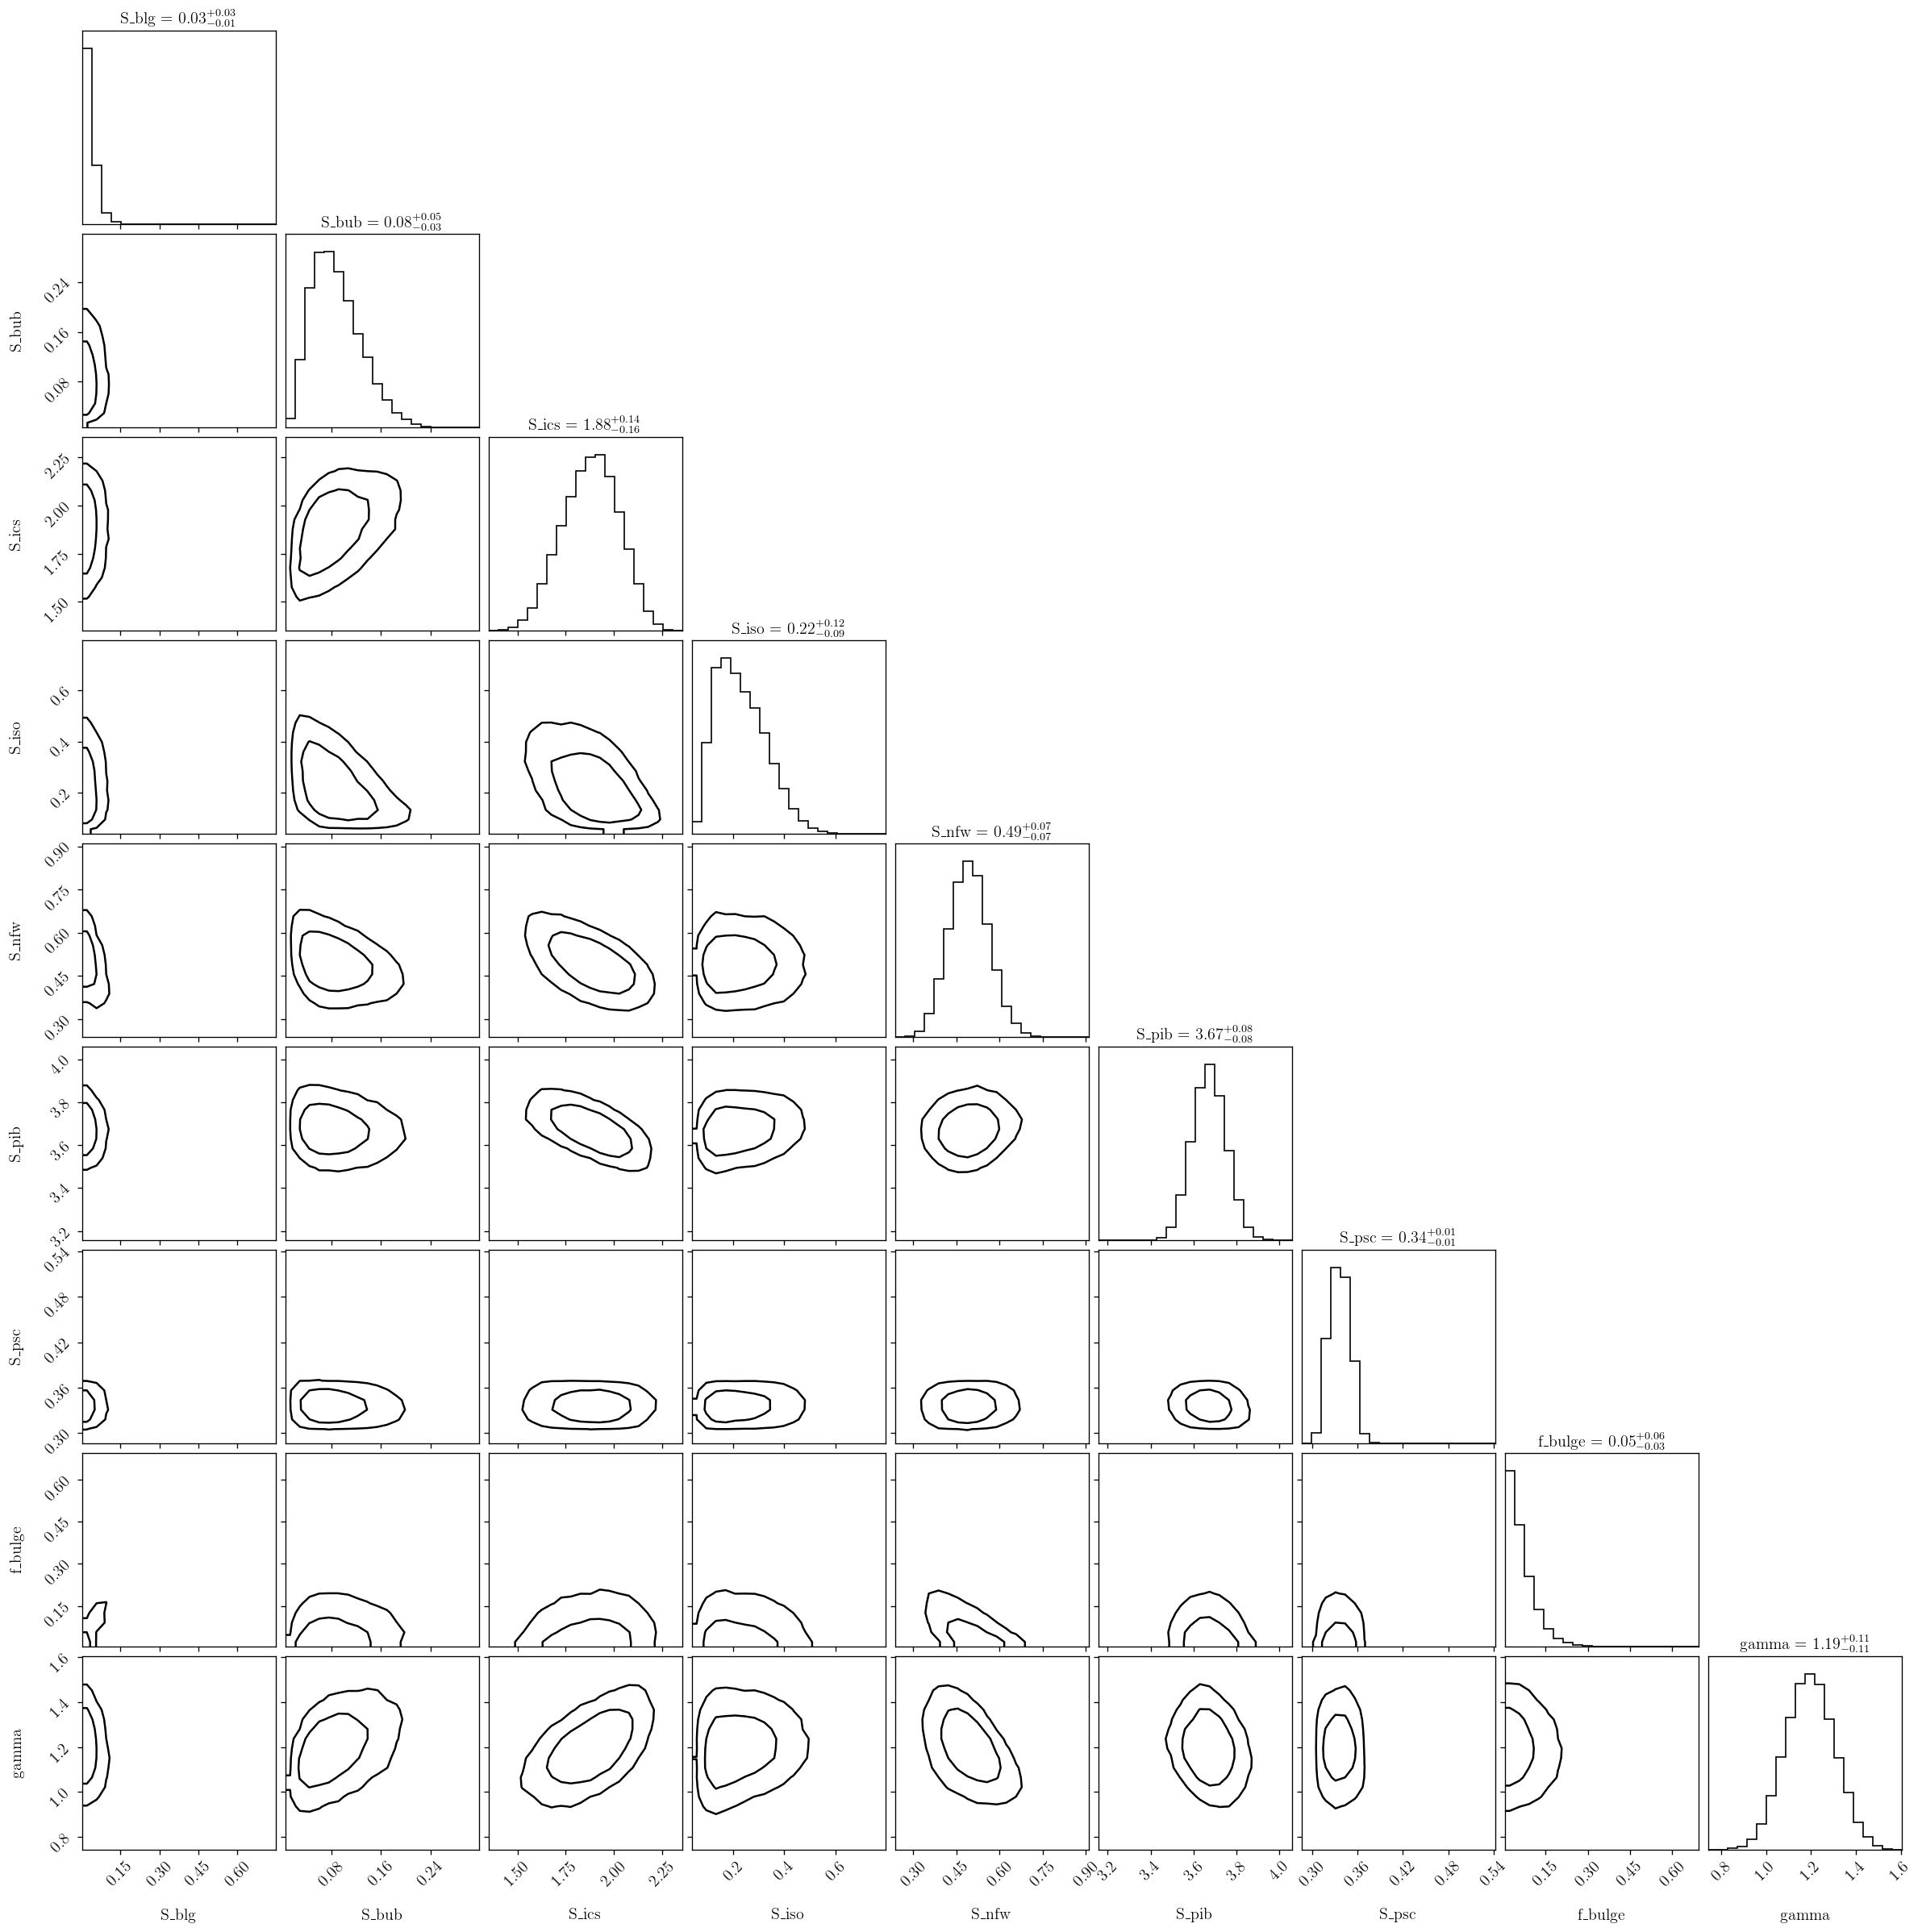

In [10]:
plot_var_names = [
    'S_blg', 'S_bub', 'S_ics', 'S_iso', 'S_nfw', 'S_pib', 'S_psc', 'f_bulge', 'gamma'
]

corner.corner(
    expanded_samples,
    #bins_1d_arr=bins_1d_arr,
    var_names=plot_var_names,
    show_titles=True,
    title_kwargs={"fontsize": 12},
    levels = [0.68, 0.95],
    #color = mpl.colors.to_hex(mpl.colors.to_rgb(f'C{i}') + (alphas[i],), keep_alpha=True),
    plot_contours=True,
    fill_contours=False,
    plot_density=False,
    plot_datapoints=False,
    #fig=figure,
    #alpha=alphas[i]
)

### 2.1 Multiple

In [10]:
samples_arr = []
for ie in tqdm(range(10, 20)):
    samples_arr.append(pickle.load(open(f'{data_dir}/test_bin{ie}.p', 'rb')))
    if 'auto_shared_latent' in samples_arr[-1]:
        samples_arr[-1].pop('auto_shared_latent')
        print(f'{ie}: auto_shared_latent popped')

100%|███████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 89.76it/s]


In [11]:
# clip
for s in samples_arr:
    s['S_blg'] = np.clip(s['S_blg'], None, 1.)
for s in samples_arr:
    s['S_pib'] = np.clip(s['S_pib'], None, 5.)
for s in samples_arr:
    s['S_ics'] = np.clip(s['S_ics'], None, 5.)

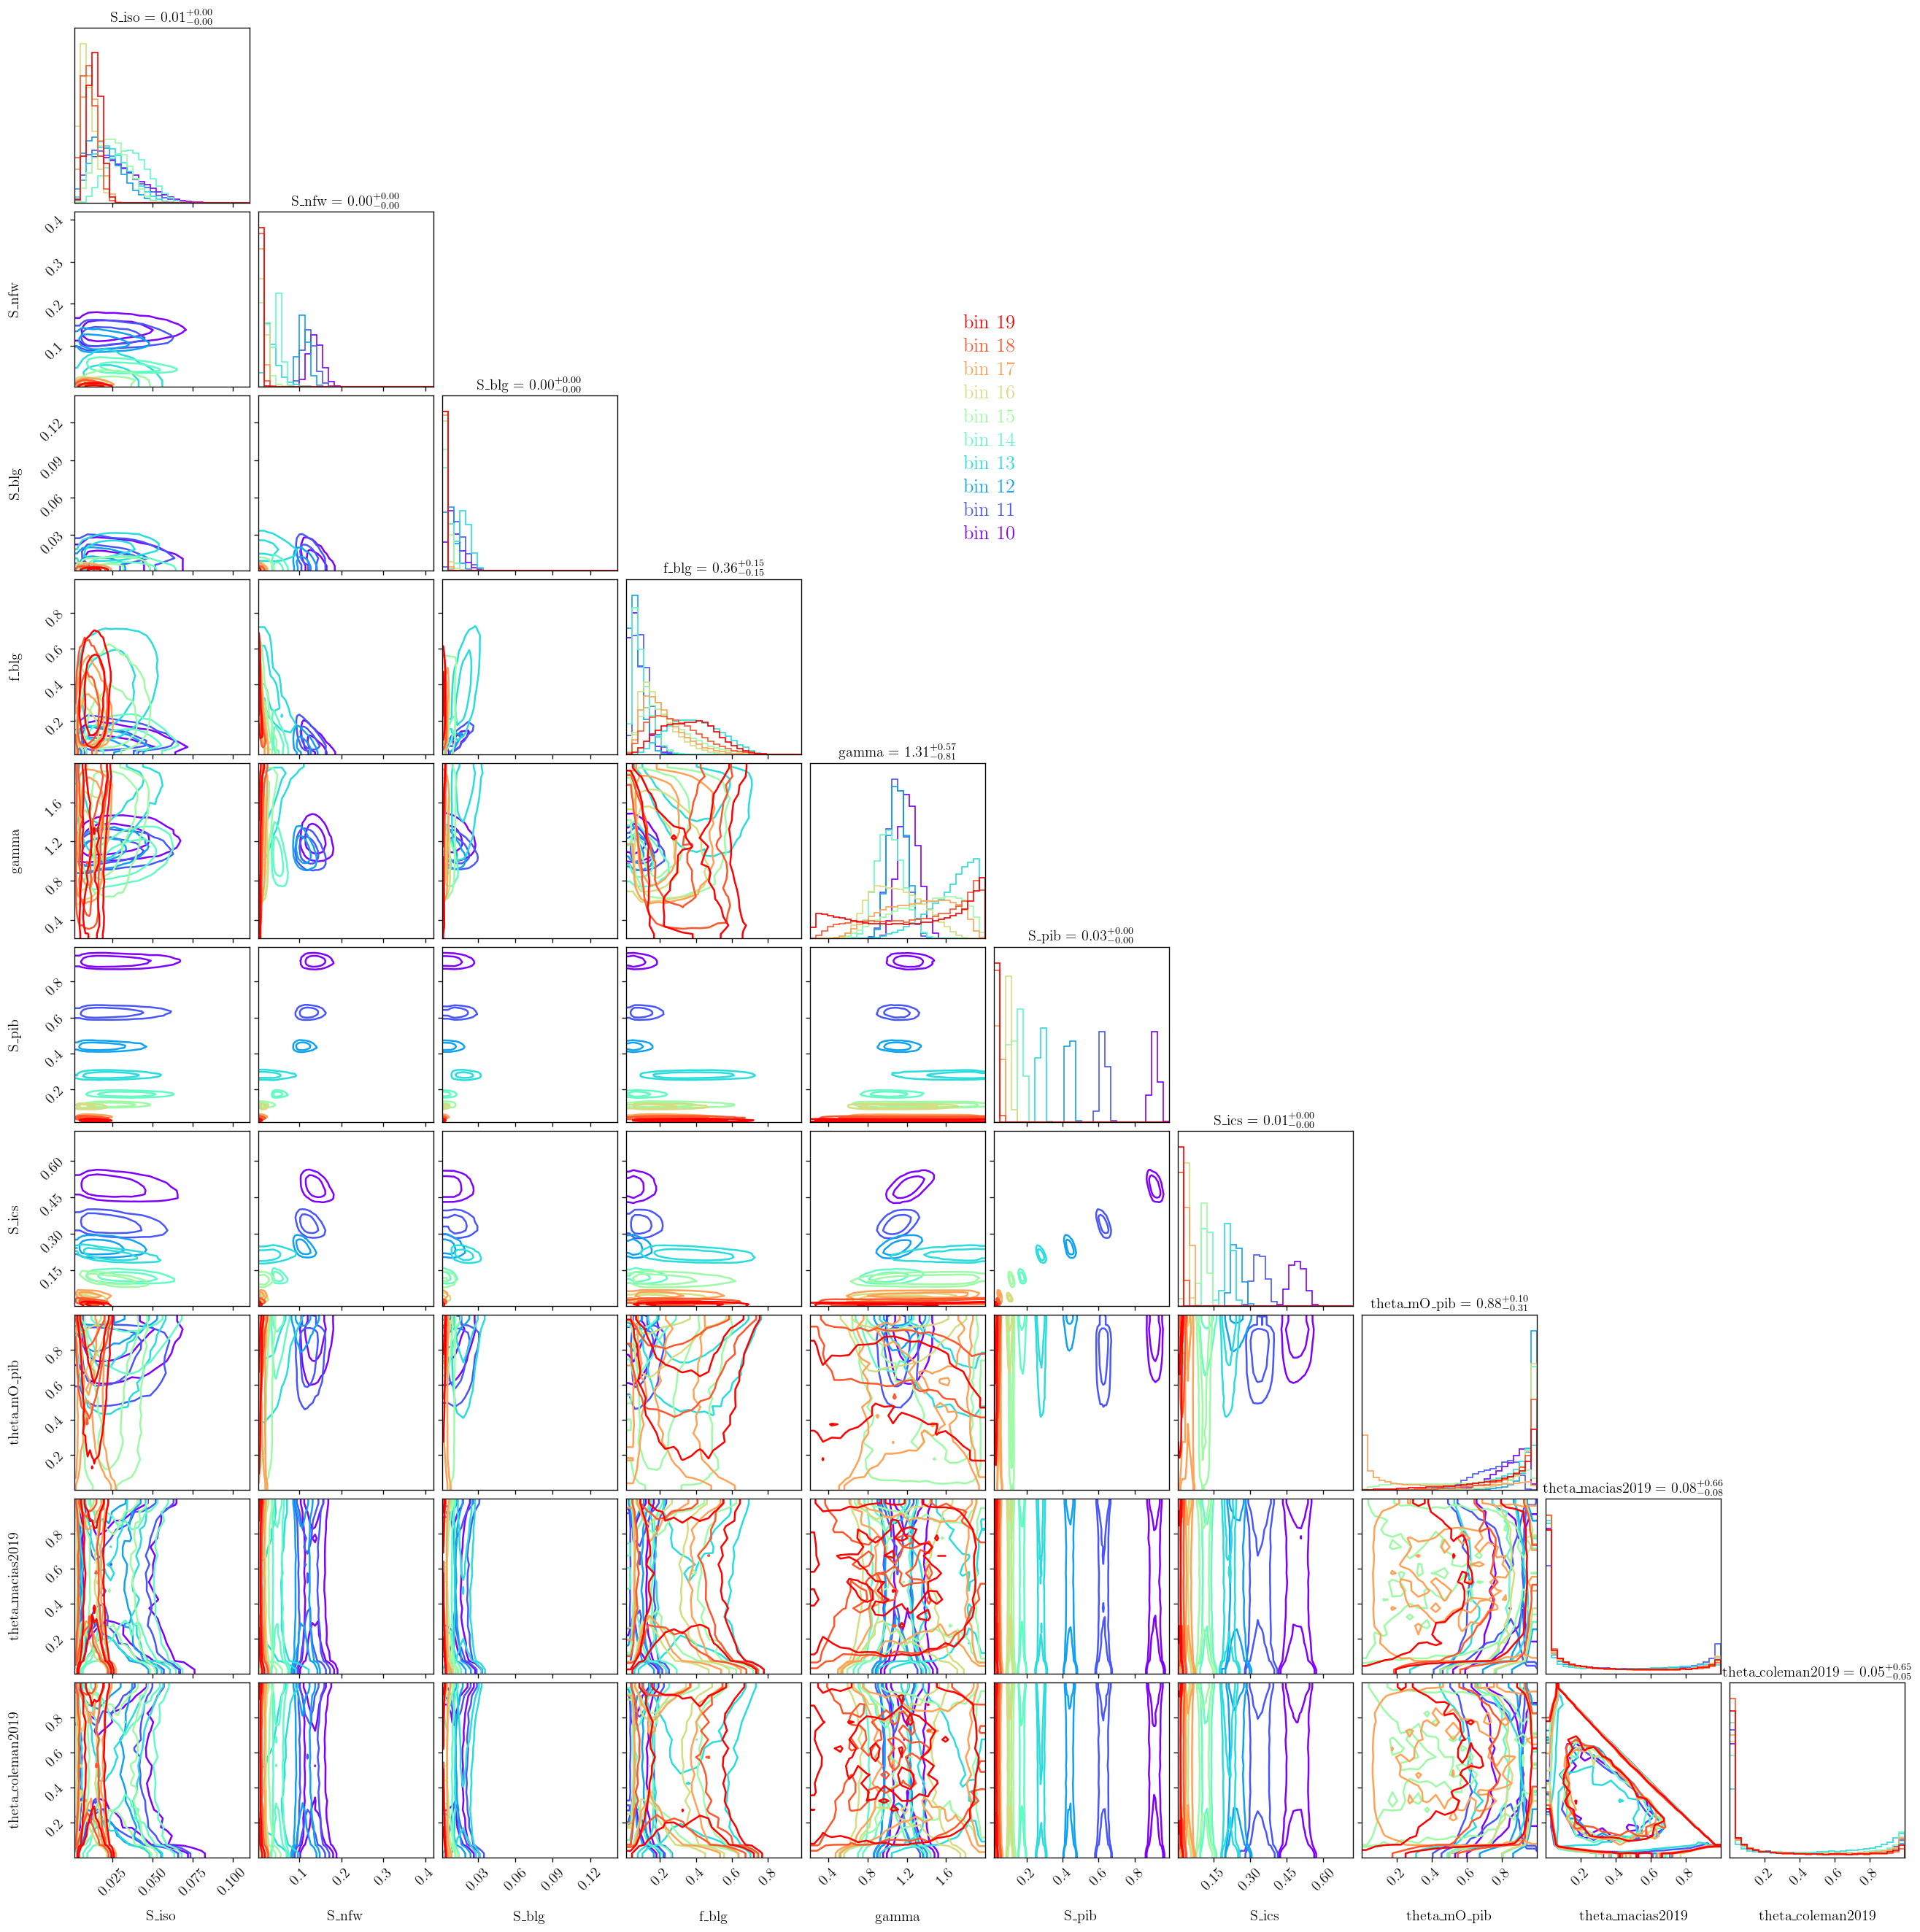

In [13]:
plot_var_names = [
    'S_iso', 'S_nfw', 'S_blg', 'f_blg', 'gamma', 'S_pib', 'S_ics',
    'theta_mO_pib', 'theta_macias2019', 'theta_coleman2019',
]

n_bins_1d = 30
bins_1d_arr = []
for vn in plot_var_names:
    vmin = np.min([np.min(s[vn]) for s in samples_arr])
    vmax = np.max([np.max(s[vn]) for s in samples_arr])
    bins_1d_arr.append(np.linspace(vmin, vmax, n_bins_1d + 1))

figure = None
for ie, samples in zip(list(range(10, 20)), samples_arr):
    color = mpl.cm.get_cmap('rainbow')((ie-10)/9)
    figure = corner.corner(
        samples,
        bins_1d_arr=bins_1d_arr,
        var_names=plot_var_names,
        show_titles=True,
        title_kwargs={"fontsize": 12},
        levels = [0.68, 0.95],
        #color = mpl.colors.to_hex(mpl.colors.to_rgb(f'C{i}') + (alphas[i],), keep_alpha=True),
        color = mpl.colors.to_hex(color, keep_alpha=True),
        plot_contours=True,
        fill_contours=False,
        plot_density=False,
        plot_datapoints=False,
        fig=figure,
        #alpha=alphas[i]
    )
    figure.text(0.5, 0.6+0.012*ie, f'bin {ie}', fontsize=16, color=color)
#plt.savefig('compare.pdf')

In [ ]:
plot_var_names = [
    'S_blg', 'S_bub', 'S_ics', 'S_iso', 'S_nfw', 'S_pib', 'S_psc', 'f_bulge', 'gamma'
]

corner.corner(
    expanded_samples,
    #bins_1d_arr=bins_1d_arr,
    var_names=plot_var_names,
    show_titles=True,
    title_kwargs={"fontsize": 12},
    levels = [0.68, 0.95],
    #color = mpl.colors.to_hex(mpl.colors.to_rgb(f'C{i}') + (alphas[i],), keep_alpha=True),
    plot_contours=True,
    fill_contours=False,
    plot_density=False,
    plot_datapoints=False,
    #fig=figure,
    #alpha=alphas[i]
)

# Appendix

## A1. view

In [36]:
from utils.cart import to_cart

In [45]:
n_pixels = 80
pixelsize = 0.5

mask_roi_cart = to_cart(ebinmodel.mask_rois[10], n_pixels=n_pixels, pixelsize=pixelsize) > 0

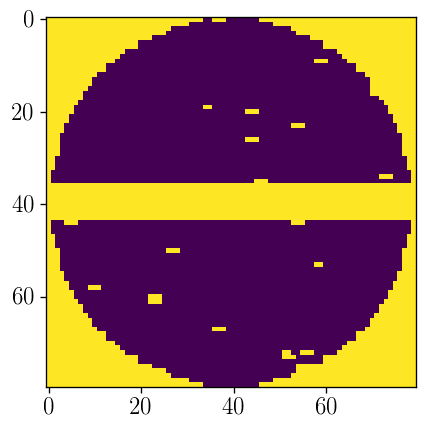

In [48]:
plt.imshow(mask_roi_cart)

## A2. Point estimates

In [24]:
results = []
methods = ['scipy minimize', 'scipy shgo', 'jax.scipy minimize']
for method in methods:
    print(method)
    results.append(ebinmodel.fit_MLE_at_bin(15, method=method))

scipy minimize
scipy shgo
jax.scipy minimize


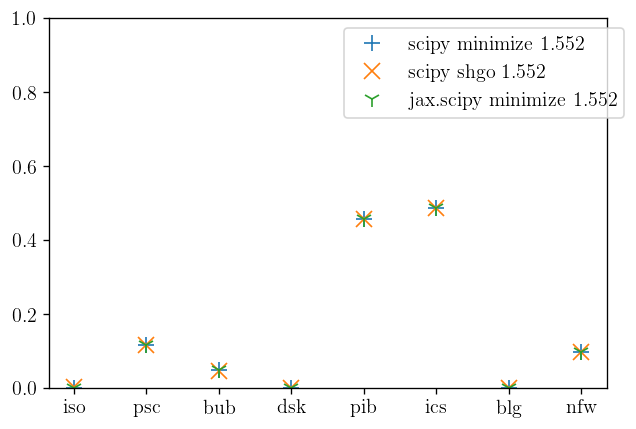

In [37]:
m_s = ['+', 'x', '1']

fig, ax = plt.subplots()
for method, result, m in zip(methods, results, m_s):
    ax.plot(np.exp(result.x), marker=m, ls='None', ms=10, label=method+f' {result.fun:.3f}')

ax.set(ylim=(0,1))
ax.set_xticks(list(range(8)))
ax.set_xticklabels(['iso', 'psc', 'bub', 'dsk', 'pib', 'ics', 'blg', 'nfw'])
ax.legend(bbox_to_anchor=(1.05, 1.0));